In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import concordance_index_censored
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors

def evaluate_model(params, X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=params.get('random_state'))
    c_indices_train = []

    # 归一化整个训练集
    scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # 事件状态和SMOTE重采样
    y_train_events = y_train['event'].astype(int)
    smote = SMOTE(random_state=params.get('random_state'))
    X_train_resampled, y_train_resampled_events = smote.fit_resample(X_train_scaled, y_train_events)

    # 使用最近邻方法找到与重采样后样本最接近的原始样本的时间数据
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(X_train_scaled)
    _, indices = nn.kneighbors(X_train_resampled)
    y_train_resampled_times = y_train['time'][indices.flatten()]

    # 重新组装 y_train_resampled
    y_train_resampled = np.array([(event, time) for event, time in zip(y_train_resampled_events, y_train_resampled_times)],
                                 dtype=[('event', bool), ('time', '<f8')])

    # K折训练集C指数
    for train_index, test_index in kf.split(X_train_resampled):
        X_train_kf, X_test_kf = X_train_resampled[train_index], X_train_resampled[test_index]
        y_train_kf, y_test_kf = y_train_resampled[train_index], y_train_resampled[test_index]

        model = FastSurvivalSVM(**params)
        model.fit(X_train_kf, y_train_kf)

        predictions_train_kf = model.predict(X_test_kf)
        result_train_kf = concordance_index_censored(y_test_kf['event'], y_test_kf['time'], predictions_train_kf)
        c_index_train_kf = result_train_kf[0]
        c_indices_train.append(c_index_train_kf)

    mean_c_index_train = np.mean(c_indices_train)
    return mean_c_index_train

def evaluate_validation(params, X_train, y_train, X_val, y_val):
    scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = FastSurvivalSVM(**params)
    model.fit(X_train_scaled, y_train)
    predictions_val = model.predict(X_val_scaled)
    result_val = concordance_index_censored(y_val['event'], y_val['time'], predictions_val)
    c_index_val = result_val[0]

    return c_index_val

# 加载和准备数据
data = pd.read_csv('dataset.csv')
X = data.drop(['follow_Up', 'outcome'], axis=1)
y = np.array([(event, time) for event, time in zip(data['outcome'], data['follow_Up'])],
             dtype=[('event', bool), ('time', '<f8')])

param_grid = {
    'alpha': [0.1],
    'max_iter': [100],
    'tol': [1e-4]
}

best_c_index_train = 0
best_params = None

random_seed = 45
np.random.seed(random_seed)

# 分层抽样划分数据集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=data['outcome'])

# 参数搜索
for alpha in param_grid['alpha']:
    for max_iter in param_grid['max_iter']:
        for tol in param_grid['tol']:
            params = {
                'alpha': alpha,
                'max_iter': max_iter,
                'tol': tol,
                'random_state': random_seed
            }

            mean_c_index_train = evaluate_model(params, X_train, y_train)
            mean_c_index_val = evaluate_validation(params, X_train, y_train, X_val, y_val)

            if mean_c_index_train <= 1.1 * mean_c_index_val and mean_c_index_train > best_c_index_train:
                best_c_index_train = mean_c_index_train
                best_params = params

# 最佳参数训练和验证集评估
if best_params:
    scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    best_model = FastSurvivalSVM(**best_params)
    best_model.fit(X_train_scaled, y_train)  # 注意这里使用原始数据，没使用重采样后的数据

    predictions_val = best_model.predict(X_val_scaled)
    result_val = concordance_index_censored(y_val['event'], y_val['time'], predictions_val)
    best_c_index_val = result_val[0]

    print(f"Best training C-index: {best_c_index_train} with parameters: {best_params}")
    print(f"Corresponding validation C-index: {best_c_index_val}")


Best training C-index: 0.7635624601689944 with parameters: {'alpha': 0.1, 'max_iter': 100, 'tol': 0.0001, 'random_state': 45}
Corresponding validation C-index: 0.7837837837837838


C:\Users\30952\AppData\Roaming\Python\Python311\site-packages\sksurv\metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


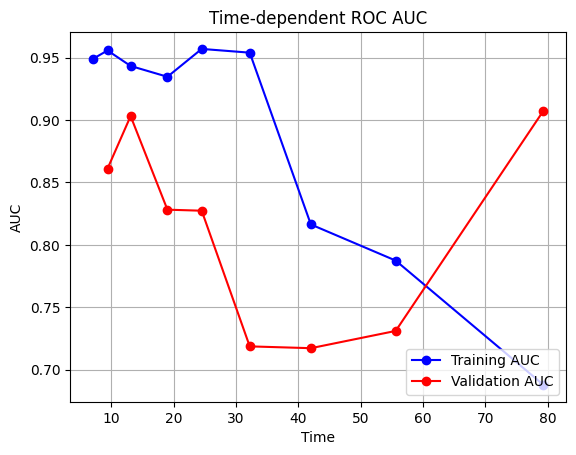

In [2]:
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc

# 定义绘制time-dependent ROC curve函数
def plot_time_dependent_roc(model, X_train, y_train, X_val, y_val):
    # 使用训练集时间的分位数作为评估点
    times = np.percentile(y_train['time'], np.arange(10, 91, 10))
    aucs = []
    for time in times:
        # 获取训练集和验证集的风险分数
        risk_scores_train = model.predict(X_train)
        risk_scores_val = model.predict(X_val)
        
        # 计算训练集和验证集在当前时间点的AUC
        train_auc = cumulative_dynamic_auc(y_train, y_train, risk_scores_train, time)[0]
        val_auc = cumulative_dynamic_auc(y_train, y_val, risk_scores_val, time)[0]
        aucs.append((train_auc, val_auc))
    
    train_aucs, val_aucs = zip(*aucs)
    
    plt.figure()
    plt.plot(times, train_aucs, marker='o', linestyle='-', color='blue', label='Training AUC')
    plt.plot(times, val_aucs, marker='o', linestyle='-', color='red', label='Validation AUC')
    plt.xlabel('Time')
    plt.ylabel('AUC')
    plt.title('Time-dependent ROC AUC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# 绘制time-dependent ROC curve
plot_time_dependent_roc(best_model, X_train_scaled, y_train, X_val_scaled, y_val)

C:\Users\30952\.conda\envs\MayTwentytest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 168/168 [00:30<00:00,  5.45it/s]


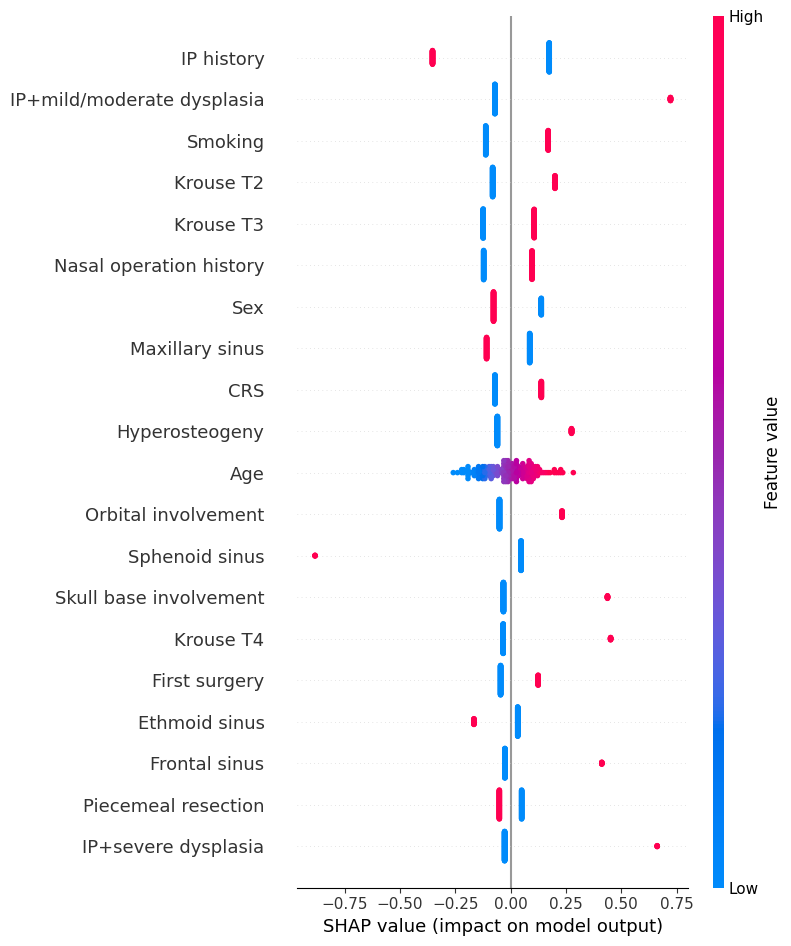

In [3]:
import shap
import matplotlib.pyplot as plt

# 设置全局字体大小
plt.rcParams.update({'font.size': 8})

# 确保使用已经训练好的最佳模型实例
model = best_model

# 使用KernelExplainer计算SHAP值
def predict_function(X):
    # 使用预训练的模型预测风险分数
    return model.predict(X)

# 对KernelExplainer的训练数据子集进行采样
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

explainer = shap.KernelExplainer(predict_function, background)
shap_values = explainer.shap_values(X_train_scaled, nsamples=100)  #减少n个样本以加快计算速度

# SHAP图
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns.tolist(), show=False)
# 保存 SHAP summary plot 为 TIFF 格式
plt.savefig('shap_summary_plot.tif', format='tiff', dpi=300)  # 300 dpi 用于高质量图像
# 显示图像
plt.show()

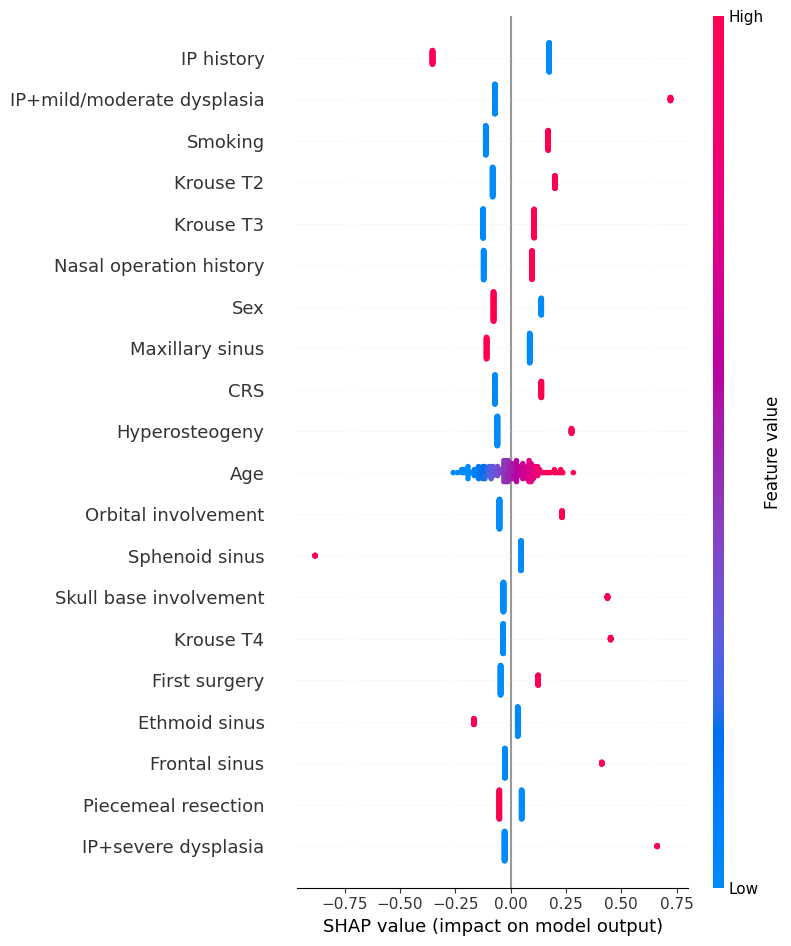

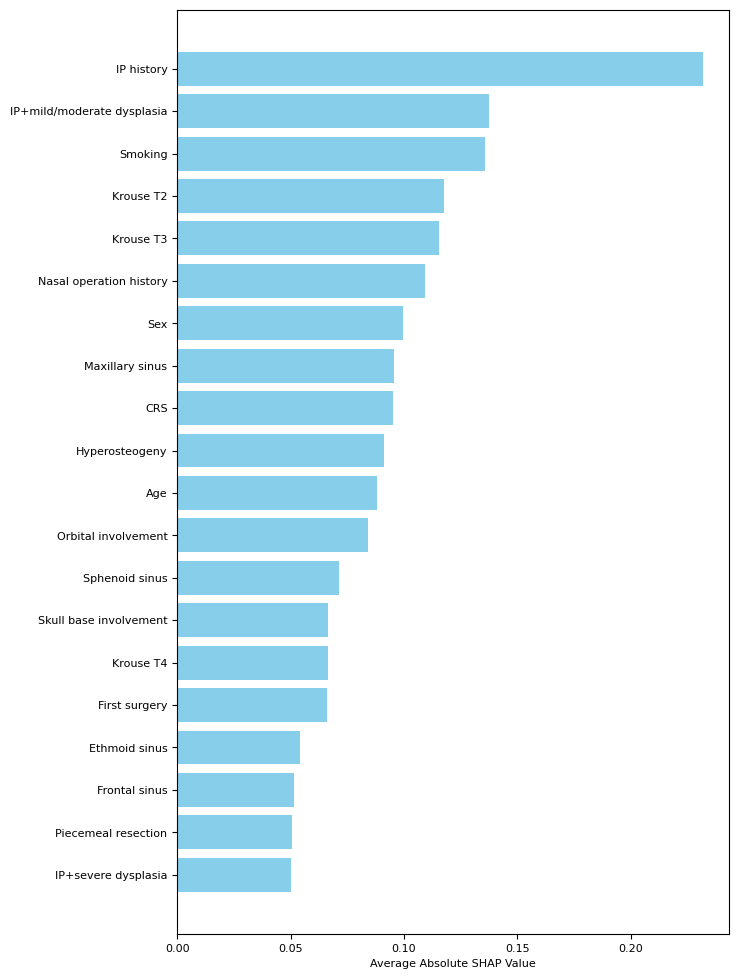

In [4]:
# SHAP图
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns.tolist())

# 计算所有特征的平均绝对SHAP值
shap_abs_mean = np.abs(shap_values).mean(axis=0)

# 获取特征名称并与它们的平均绝对SHAP值配对，然后根据SHAP值排序
feature_importance = sorted(zip(X.columns, shap_abs_mean), key=lambda x: x[1], reverse=True)

# 解压排序后的配对列表
features_sorted, shap_values_sorted = zip(*feature_importance)

# 只取前20个重要特征及其SHAP值
features_sorted_top20 = features_sorted[:20]
shap_values_sorted_top20 = shap_values_sorted[:20]

# 绘制直方图
plt.figure(figsize=(8, 12))
plt.subplots_adjust(left=0.21)  # 调整左侧边距
plt.barh(features_sorted_top20, shap_values_sorted_top20, color='skyblue')
plt.xlabel('Average Absolute SHAP Value')
plt.gca().invert_yaxis()  # 使得重要性最高的特征在顶部
plt.savefig('top20_feature_importance.tif', format='tiff', dpi=300)  # 300 dpi 用于高质量图像
plt.show()